In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nbimporter

import central_system as cs
import analyze_control as ac

import exp_study_case
import exp_external_conditions
import exp_system_spec
import exp_house_spec
import exp_general_property
import exp_occupant_usage
import exp_circulating_air_flow

Importing Jupyter notebook from exp_study_case.ipynb
Importing Jupyter notebook from exp_external_conditions.ipynb
Importing Jupyter notebook from exp_system_spec.ipynb
Importing Jupyter notebook from exp_house_spec.ipynb
Importing Jupyter notebook from exp_general_property.ipynb
Importing Jupyter notebook from exp_occupant_usage.ipynb
Importing Jupyter notebook from exp_circulating_air_flow.ipynb


# 0. 検討ケース

試算するケースを取得します。

In [2]:
case = exp_study_case.get_case()
case

{'region': 6,
 'house': {'a_mr': 29.81,
  'a_or': 51.34,
  'a_a': 120.08,
  'r_env': 2.9555555555555557,
  'insulation': 'h11',
  'solar_gain': 'middle'},
 'system': {'default_heat_source_spec': True,
  'v_hs_rtd_h': 1800.0,
  'v_hs_rtd_c': 1800.0,
  'is_duct_insulated': True,
  'vav_system': False,
  'cap_rtd_h': None,
  'cap_rtd_c': None}}

1日グラフを描画する日を取得します。

In [3]:
hday, cday = exp_study_case.get_display_day()
hday, cday

('2/23', '9/1')

## 1. 外部モジュールの読み込み

### 熱源機の仕様

外部モジュール exp_system_spec を参照のこと。

$q_{rtd,H}$：定格暖房能力, W  
$q_{rtd,C}$：定格冷房能力, W  
$V_{hs,rtd,H}$：熱源機の暖房時の定格風量, m<sup>3</sup>/h  
$V_{hs,rtd,C}$：熱源機の冷房時の定格風量, m<sup>3</sup>/h  

In [4]:
q_rtd_h, q_rtd_c, v_hs_rtd_h, v_hs_rtd_c, is_duct_insulated, vav_system = \
    exp_system_spec.get_system_spec(case['region'], case['house']['a_a'], case['system'])

q_rtd_h, q_rtd_c, v_hs_rtd_h, v_hs_rtd_c, is_duct_insulated, vav_system

(7733.9925600000015, 7664.646360000001, 1800.0, 1800.0, True, False)

### 住宅の仕様

外部モジュール exp_house_spec を参照のこと。  

$r_{env}$：床面積の合計に対する外皮の部位の面積の合計の比  
$A_A$：床面積の合計, m<sup>2</sup>  
$A_{MR}$：主たる居室の床面積, m<sup>2</sup>  
$A_{OR}$：その他の居室の床面積, m<sup>2</sup>  
$A_{NR}$：非居室の床面積, m<sup>2</sup>  
$A_{HCZ,R,i}$：標準住戸における暖冷房区画 $i$ の床面積, m<sup>2</sup>  
$A_{HCZ,i}$：暖冷房区画 $i$ の床面積, m<sup>2</sup>  
$A_{prt,i}$：暖冷房区画 $i$ から見た非暖冷房空間の間仕切りの面積, m<sup>2</sup>  
$U_{prt}$：間仕切りの熱貫流率, W/m<sup>2</sup>K  
$Q$：熱損失係数, W/m<sup>2</sup>K  
$\mu_H$：暖房期の日射取得係数, ((W/m<sup>2</sup>)/(W/m<sup>2</sup>))  
$\mu_C$：冷房期の日射取得係数, ((W/m<sup>2</sup>)/(W/m<sup>2</sup>))  
$V_{vent,i}$：暖冷房区画 $i$ の機械換気量, m<sup>3</sup>/h  

In [5]:
r_env, a_a, a_mr, a_or, a_nr, a_hcz, a_prt, u_prt, q, mu_h, mu_c, v_vent = \
    exp_house_spec.get_house_spec(case['region'], case['house'])
r_env, a_a, a_mr, a_or, a_nr, a_hcz, a_prt, u_prt, q, mu_h, mu_c, v_vent

(2.9555555555555557,
 120.08,
 29.81,
 51.34,
 38.92999999999999,
 array([29.81, 16.56, 13.25, 10.76, 10.77,  3.31,  1.66,  3.31, 13.25,
         4.97, 10.77,  1.66]),
 array([37.99636619, 27.7187943 , 22.17838312, 18.01052093, 18.02725933]),
 2.1739130434782608,
 2.7,
 0.101,
 0.062,
 array([60., 20., 40., 20., 20.]))

### 物性値

外部モジュール exp_general_property を参照のこと。

$\rho$：空気の密度, kg/m<sup>3</sup>  
$c$：空気の比熱, J/kgK  
$L_{wtr}$：水の蒸発潜熱, kJ/kg  
「平日」「休日」の別

In [6]:
rho, c, l_wtr, calender = exp_general_property.get_general_property()
rho, c, l_wtr, calender

(1.2,
 1006.0,
 2434.5296000000003,
 array(['休日', '休日', '休日', ..., '休日', '休日', '休日'], dtype=object))

### 気候条件

外部モジュール exp_external_conditions を参照のこと。

$\theta_{ex,d,t}$：日付$d$の時刻$t$における外気温度, ℃  
$x_{ex,d,t}$：日付$d$の時刻$t$における絶対湿度, kg/kg(DA)  
$h_{ex_d,t}$：日付$d$の時刻$t$における相対湿度, %  
$J_{d,t}$：日付$d$の時刻$t$における水平面全天日射量, W/m<sup>2</sup>  
$\theta_{SAT,d,t}$：日付$d$の時刻$t$における水平面における等価外気温度, ℃  

In [7]:
theta_ex, x_ex, h_ex, j, theta_sat = exp_external_conditions.get_external_conditions(case['region'])
theta_ex, x_ex, h_ex, j, theta_sat

(array([2.6, 2.9, 2.8, ..., 3.1, 2.7, 2.3]),
 array([0.0033, 0.0032, 0.0032, ..., 0.0032, 0.0032, 0.0032]),
 array([72.52135498, 68.85197153, 69.34240102, ..., 67.88267058,
        69.83672797, 71.8536949 ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([2.6, 2.9, 2.8, ..., 3.1, 2.7, 2.3]))

### 居住者の使い方

外部モジュール exp_occupant_usage を参照のこと。

暖房期間  
冷房期間  
$n_{p,d,t}$：日付$d$の時刻$t$における在室人数  
$q_{gen,d,t}$：日付$d$の時刻$t$における内部発熱, W  
$w_{gen,d,t}$：日付$d$の時刻$t$における内部発湿, g/h  
$V_{local,d,t}$：日付$d$時刻$t$における局所換気量, m<sup>3</sup>/h  
$\theta_{set,h}$：暖房時の設定温度, ℃  
$\theta_{set,c}$：冷房時の設定温度, ℃  

In [8]:
heating_period, cooling_period, n_p, q_gen, w_gen, v_local, theta_set_h, theta_set_c \
    = exp_occupant_usage.get_occupant_usage(case['region'], a_mr, a_or, a_nr, calender)
heating_period, cooling_period, n_p, q_gen, w_gen, v_local, theta_set_h, theta_set_c

(array([ True,  True,  True, ...,  True,  True,  True]),
 array([False, False, False, ..., False, False, False]),
 array([4., 4., 4., ..., 4., 3., 3.]),
 array([126.4, 126.4, 126.4, ..., 763. , 815. , 242.7]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([  0. ,   0. ,   0. , ...,  25. ,  27. , 100.8]),
 20.0,
 27.0)

### 循環風量

外部モジュール exp_circulating_air_flow を参照のこと。

$r_{supply,des,i}$：暖冷房区画 $i$ の風量バランス  
$V'_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ へのVAV調整前の吹き出し風量, m<sup>3</sup>/h  

In [9]:
v_d_supply = exp_circulating_air_flow.get_circulating_air_flow(
    a_a, a_hcz, q, mu_h, mu_c, v_vent, theta_ex, x_ex, j, heating_period, cooling_period, n_p, q_gen, w_gen, v_local, theta_set_h, theta_set_c,
    q_rtd_h, q_rtd_c, v_hs_rtd_h, v_hs_rtd_c)
v_d_supply

array([[468.11565231, 460.46390045, 463.0144844 , ..., 416.81045706,
        430.28097496, 519.46598863],
       [260.04680316, 255.79611511, 257.21301113, ..., 231.54582922,
        239.02894818, 288.5728538 ],
       [208.06884915, 204.66778534, 205.80147328, ..., 185.26462785,
        191.25202678, 230.89313483],
       [168.96760882, 166.20568832, 167.12632849, ..., 150.44886005,
        155.31107986, 187.50265138],
       [169.12464191, 166.36015458, 167.28165035, ..., 150.58868241,
        155.45542101, 187.67691035]])

## 2. 暖冷房室の温度

暖房時

$$ \theta_{ac,d,t} = \theta_{set,H} $$

冷房時

$$ \theta_{ac,d,t} = \theta_{set,C} $$

非暖冷房時

$$ \theta_{ac,d,t} = \left\{
\begin{array}{ll}
\theta_{ex,d,t} & \theta_{set,C,d,t} \ge \theta_{ex,d,t}, and \theta_{ex,d,t} \ge \theta_{set,H,d,t} \\
\theta_{set,C,d,t} & \theta_{ex,d,t} \gt \theta_{set,C,d,t} \\
\theta_{set,H,d,t} & \theta_{ac,H,d,t} \gt \theta_{set,d,t}
\end{array}
\right. $$

$\theta_{ac,d,t}$：日付 $d$ の時刻 $t$ における暖冷房室の温度, ℃  
$\theta_{set,H}$：暖房時の設定温度, ℃  
$\theta_{set,C}$：冷房時の設定温度, ℃  
$\theta_{ex,d,t}$：日付$d$の時刻$t$における外気温度, ℃  

In [10]:
theta_ac = cs.get_air_conditioned_room_temperature(heating_period, cooling_period, theta_ex, theta_set_h, theta_set_c)

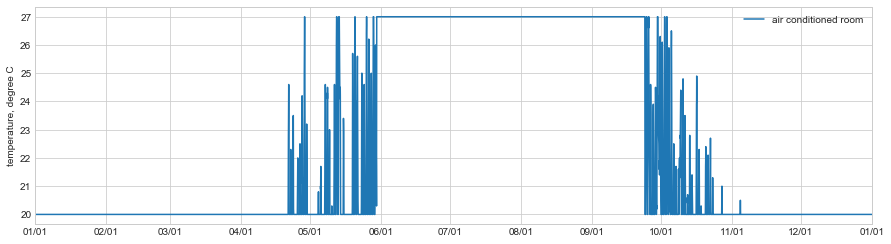

In [11]:
ac.draw_graph(y_title='temperature, degree C',
              ys=[(theta_ac, 'air conditioned room')],
              op='raw')

## 2. 暖冷房負荷

室 $i$ の暖房負荷 $L_{H,d,t,i}$ 、顕熱冷房負荷 $L_{CS,d,t,i}$ 、潜熱冷房負荷 $L_{CL,d,t,i}$ は、主たる居室・その他の居室の床面積、床面積の合計、断熱性能、日射熱取得性能に応じて決定される。（ここではいう負荷とは、室内環境の影響等の補正が入った後の負荷のことを言う。）

In [12]:
l_h, l_cs, l_cl = cs.get_load(region=case['region'], insulation=case['house']['insulation'], solar_gain=case['house']['solar_gain'],
                  a_mr=case['house']['a_mr'], a_or=case['house']['a_or'], a_a=case['house']['a_a'], r_env=case['house']['r_env'])

In [13]:
def make_list(load_data):

    return [(load_data[0], 'room 1'),
            (load_data[1], 'room 2'),
            (load_data[2], 'room 3'),
            (load_data[3], 'room 4'),
            (load_data[4], 'room 5'),
            (np.sum(load_data[0:5], axis=0), 'room 1-5'),
            (np.sum(load_data, axis=0), 'room 1-12')]

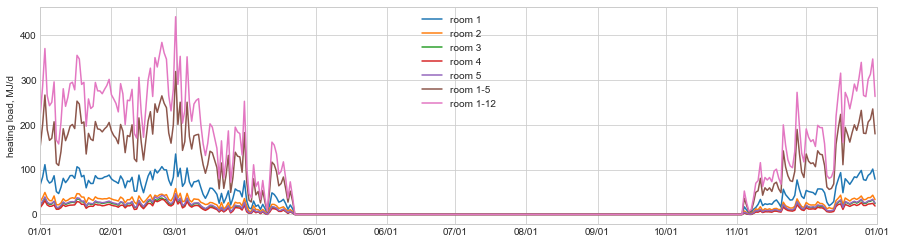

In [14]:
ac.draw_graph('heating load, MJ/d', make_list(l_h), 'itg')

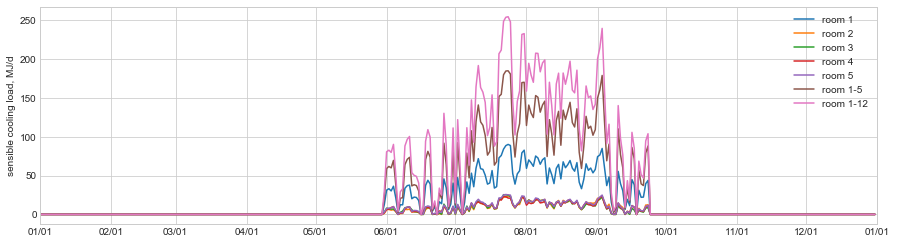

In [15]:
ac.draw_graph('sensible cooling load, MJ/d', make_list(l_cs), 'itg')

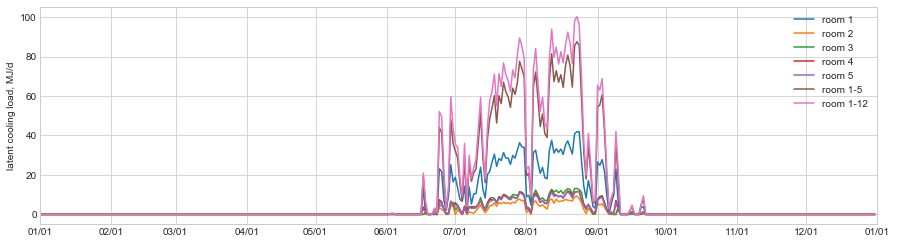

In [16]:
ac.draw_graph('latent cooling load, MJ/d', make_list(l_cl), 'itg')

## 3. 外部モジュールへの引き渡し

本モジュールを外部のモジュールから呼び出して必要な値を取得する場合に利用する関数を定義します。

In [17]:
def get_load(region, house_spec, heating_period, cooling_period, theta_ex, theta_set_h, theta_set_c):
    
    theta_ac = cs.get_air_conditioned_room_temperature(heating_period, cooling_period, theta_ex, theta_set_h, theta_set_c)
    
    l_h, l_cs, l_cl = cs.get_load(region=region, insulation=house_spec['insulation'], solar_gain=house_spec['solar_gain'],
                                  a_mr=house_spec['a_mr'], a_or=house_spec['a_or'], a_a=house_spec['a_a'], r_env=house_spec['r_env'])
    
    return theta_ac, l_h, l_cs, l_cl